In [141]:
import pickle
import numpy as np

ddir = "../../tonemap/bf_data/Nair_and_Abraham_2010/"

fn = ddir + "all_gals_w_asym.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

good_gids = np.array([gal['img_name'] for gal in all_gals])

from astrobf.utils.misc import load_Nair
cat_data = load_Nair(ddir + "catalog/table2.dat")
# pd dataframe

cat = cat_data[cat_data['ID'].isin(good_gids)]

tmo_params = {'b': 6.0,  'c': 3.96, 'dl': 9.22, 'dh': 2.45}


In [153]:
from scipy.ndimage import shift

def recenter(img, mask, weight, asym_center):
    """
    shift images and return stacked array
    """
    return (shift(img,    np.array(img.shape)/2. - asym_center[::-1]),
            shift(mask,   np.array(img.shape)/2. - asym_center[::-1], order=0).astype(bool),
            shift(weight, np.array(img.shape)/2. - asym_center[::-1]))

In [157]:
ag

{'data': array([[[  2.96466723e-02,   1.17256446e-02,   8.51422828e-03, ...,
           -2.07849755e-03,   3.29127978e-03,   2.11161692e-02],
         [  1.06468061e-02,   1.61120091e-02,   1.50238294e-02, ...,
            5.04583940e-02,   4.10110168e-02,   3.47024761e-02],
         [ -2.19587162e-02,  -2.41310452e-03,  -9.21472907e-03, ...,
            4.21487987e-02,   3.24134156e-02,   3.05575449e-02],
         ..., 
         [  2.28798911e-02,  -1.51370689e-02,  -4.50270325e-02, ...,
            8.22725445e-02,   3.09940074e-02,   2.80134995e-02],
         [ -4.94192168e-02,  -2.20858511e-02,   2.54059359e-02, ...,
            9.18985754e-02,   9.22440663e-02,   7.12182820e-02],
         [ -1.93728469e-02,   2.17142235e-02,   3.33185145e-03, ...,
            9.80341360e-02,   1.16838045e-01,   1.08870566e-01]],
 
        [[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
         [  0.00000000e+00,   0.0000

In [158]:
new_list=[]
for ag,cc in zip(all_gals, cat.iterrows()):
    gid = cc[1]["ID"]
    assert gid == ag['img_name']
    t_type = cc[1]['TT']
    img, mask, weight = recenter(*ag["data"], ag['asym_center'])
    new_list.append({'image':img, 'mask':mask, 'weight':weight, 'img_name':ag['img_name'],
                     'slices':ag['slices'], 'tt':t_type})

In [159]:
pickle.dump(new_list, open(ddir + 'all_gals_recentered.pickle', 'wb'))

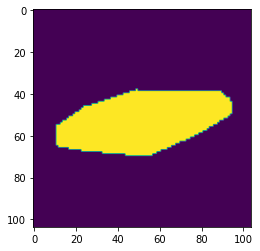

In [156]:
plt.imshow(mask)

In [160]:
all_gals = pickle.load(open(ddir + 'all_gals_recentered.pickle', 'rb'))

In [163]:
import matplotlib.pyplot as plt 

from PIL import Image
from typing import Any, Callable, Optional, Tuple
from torchvision.datasets.vision import VisionDataset
from functools import partial
from astrobf.tmo import Mantiuk_Seidel

class TonemapImageDataset(VisionDataset):
    def __init__(self, 
                 data_array, 
                 tmo,
                 labels: Optional = None, 
                 train: bool=True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,):
        self._array = data_array
        self._good_gids = np.array([gal['img_name'] for gal in data_array])
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.tmo = tmo
        self._bad_tmo=False

    def _apply_tm(self, image):
        try:
            return self.tmo(image)
        except ZeroDivisionError:
            print("division by zero. Probably bad choice of TM parameters")
            self._bad_tmo=True
            return image

    def _to_8bit(self, image):
        """
        Normalize per image (or use global min max??)
        """

        image = (image - image.min())/image.ptp()
        image *= 255
        return image.astype('uint8')        
    
    def __len__(self) -> int:
        return len(self._array)
    
    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        """
        For super
        """
        image, _segmap = self._array[idx]['image'],self._array[idx]['mask']#,self._array[idx]['weight']
        image[~_segmap] = 0#np.nan # Is it OK to have nan?
        image[image < 0] = 0

        image = self._to_8bit(self._apply_tm(image))
        image = Image.fromarray(image)
        try:
            label = self.img_labels[idx]
        except:
            label = self._array[idx]['tt']
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label


In [164]:
all_data = TonemapImageDataset(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                 labels=None, #cat['TT'].to_numpy(),
                                 train=False, 
                                 transform=None)

In [93]:
import os

In [94]:
data_dir = "../../tonemap/bf_data/ImageDataset/Nair/"
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [197]:
def finite_log(img, min_off=0.5):
    """
    parameter
    ---------
        min_off: ignore given fraction of dim pixels.
        
    NOTE
    ----
        min_off isn't very important, but 0.5 looks fine.
    """
    vmin = np.percentile(img.ravel(), min_off*100.)
    imgl = np.log10(img - 0.5*vmin)
    ind = np.isfinite(imgl)
    imgl[~ind] = imgl[ind].min()
    imgl -= imgl.min()
    ind = imgl > 0
    imgl[ind] -= imgl[ind].min()
    
    return imgl

def _to_8bit(image):
    """
    Normalize per image (or use global min max??)
    """

    image = (image - image.min())/image.ptp()
    image *= 255
    return image.astype('uint8') 

def scale_img(gal, min_off=0.5):
    image, _segmap = gal['image'],gal['mask']
    image[~_segmap] = 0
    image[image < 0] = 0
    
    
    return finite_log(image, min_off=min_off)

<ipython-input-178-6ade506f8249>:3: RuntimeWarning: divide by zero encountered in log10
  imgl = np.log10(img - 0.5*vmin)


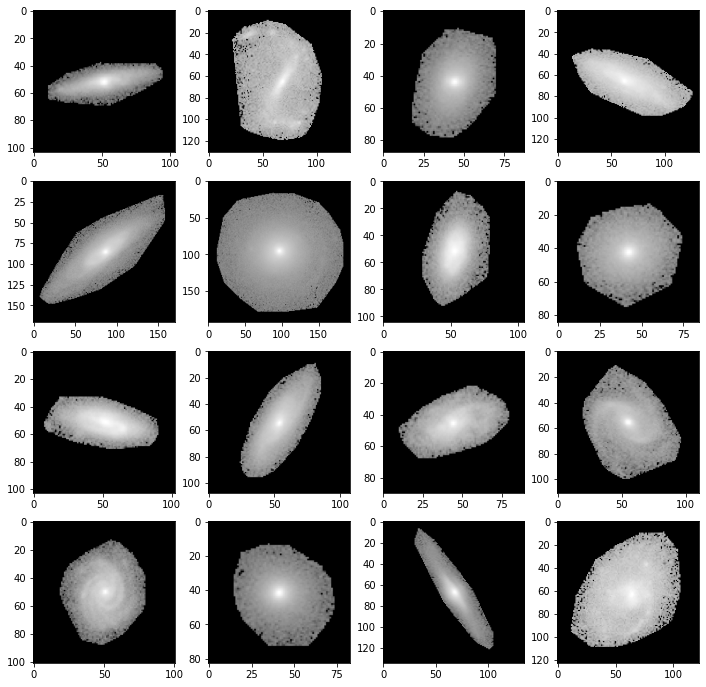

In [182]:
plt.close('all')

fig, axs = plt.subplots(4,4)
fig.set_size_inches(12,12)
axs = axs.ravel()

for ax, ag in zip(axs, all_gals[:16]):
    tt = ag['tt']
    gid = ag['img_name']
    image = _to_8bit(scale_img(ag))
    image = Image.fromarray(image)
    
    ax.imshow(image, cmap='gray')

In [199]:
for ag in all_gals:
    tt = ag['tt']
    gid = ag['img_name']
    image = _to_8bit(scale_img(ag, min_off=0.5))
    image = Image.fromarray(image)
    
    tdir = data_dir + f'{tt}/'
    if not os.path.isdir(tdir):
        os.mkdir(tdir)
        
    image.save(tdir+f'{gid}.png')

<ipython-input-197-fbf6cda52b46>:3: RuntimeWarning: divide by zero encountered in log10
  imgl = np.log10(img - 0.5*vmin)
<ipython-input-197-fbf6cda52b46>:3: RuntimeWarning: invalid value encountered in log10
  imgl = np.log10(img - 0.5*vmin)


In [19]:
ls datasets/Nair/

0/  1/  10/  11/  12/  -2/  2/  -3/  3/  4/  -5/  5/  6/  7/  8/  9/  99/


저장된 이미지 크기가 제각각이지만 상관없음, 어차피 crop할거라. 